<a href="https://colab.research.google.com/github/ah-lan/ah-lan/blob/main/hybrid%2BGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install deap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.5 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, TimeDistributed, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt
from deap import base, creator, tools, algorithms
import random
import warnings
warnings.filterwarnings('ignore')

In [7]:
train_data = pd.read_csv("/U001_train_intention.csv")
test_data = pd.read_csv("/U001_test_intention.csv")

In [8]:
imu_sensors = ['B6', '3B', 'BB', 'C9', 'B5']
features = [
    'Axel_X_B6', 'Axel_Y_B6', 'Axel_Z_B6', 'Gyro_X_B6', 'Gyro_Y_B6', 'Gyro_Z_B6',
    'Axel_X_C9', 'Axel_Y_C9', 'Axel_Z_C9', 'Gyro_X_C9', 'Gyro_Y_C9', 'Gyro_Z_C9',
    'Axel_X_3B', 'Axel_Y_3B', 'Axel_Z_3B', 'Gyro_X_3B', 'Gyro_Y_3B', 'Gyro_Z_3B',
    'Axel_X_BB', 'Axel_Y_BB', 'Axel_Z_BB', 'Gyro_X_BB', 'Gyro_Y_BB', 'Gyro_Z_BB',
    'Axel_X_B5', 'Axel_Y_B5', 'Axel_Z_B5', 'Gyro_X_B5', 'Gyro_Y_B5', 'Gyro_Z_B5'
]

# ================== Preprocessing ==================
def butter_lowpass_filter(data, cutoff=5.0, fs=100.0, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

In [9]:
for feature in features:
    train_data[feature] = butter_lowpass_filter(train_data[feature].values)
    test_data[feature] = butter_lowpass_filter(test_data[feature].values)

def classify_posture_from_target(target):
    if target in [0, 1]:
        return 1  # good posture
    elif target in [2, 3]:
        return 0  # poor posture
    return np.nan

train_data['posture_label'] = train_data['target'].apply(classify_posture_from_target)
test_data['posture_label'] = test_data['target'].apply(classify_posture_from_target)

train_data.dropna(subset=['posture_label'], inplace=True)
test_data.dropna(subset=['posture_label'], inplace=True)

X_train = train_data[features].values
y_train = train_data['posture_label'].values
X_test = test_data[features].values
y_test = test_data['posture_label'].values

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1], 1))


In [10]:
# ================== CNN-LSTM Model Function ==================
def build_model(dropout_rate, lstm_units, dense_units):
    model = Sequential([
        Input(shape=(1, len(features), 1)),
        TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', padding='same')),
        TimeDistributed(MaxPooling1D(pool_size=2)),
        TimeDistributed(Conv1D(32, kernel_size=3, activation='relu', padding='same')),
        TimeDistributed(MaxPooling1D(pool_size=2)),
        TimeDistributed(Flatten()),
        LSTM(int(lstm_units), return_sequences=False),
        Dense(int(dense_units), activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [11]:
# ================== DEAP Genetic Algorithm Setup ==================
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def generate_individual():
    return [random.uniform(0.2, 0.7), random.randint(32, 128), random.randint(32, 128)]

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, generate_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    dropout, lstm_units, dense_units = individual
    model = build_model(dropout, lstm_units, dense_units)
    history = model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
    )
    _, acc = model.evaluate(X_test, y_test, verbose=0)
    return (acc,)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)


In [12]:
# ================== Run GA ==================
population = toolbox.population(n=5)
algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=3, verbose=True)

# ================== Best Model ==================
best_ind = tools.selBest(population, 1)[0]
print(f"\nBest Hyperparameters → Dropout={best_ind[0]:.2f}, LSTM Units={int(best_ind[1])}, Dense Units={int(best_ind[2])}")

final_model = build_model(*best_ind)
history = final_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

gen	nevals
0  	5     
1  	4     
2  	1     
3  	4     

Best Hyperparameters → Dropout=0.54, LSTM Units=105, Dense Units=107
Epoch 1/20
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.9620 - loss: 0.0964 - val_accuracy: 0.9429 - val_loss: 0.2013
Epoch 2/20
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.9834 - loss: 0.0407 - val_accuracy: 0.9425 - val_loss: 0.2341
Epoch 3/20
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.9841 - loss: 0.0383 - val_accuracy: 0.9491 - val_loss: 0.2532
Epoch 4/20
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9840 - loss: 0.0349 - val_accuracy: 0.9370 - val_loss: 0.3815


455/455 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9418 - loss: 0.1955

Test Accuracy: 94.29%
455/455 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


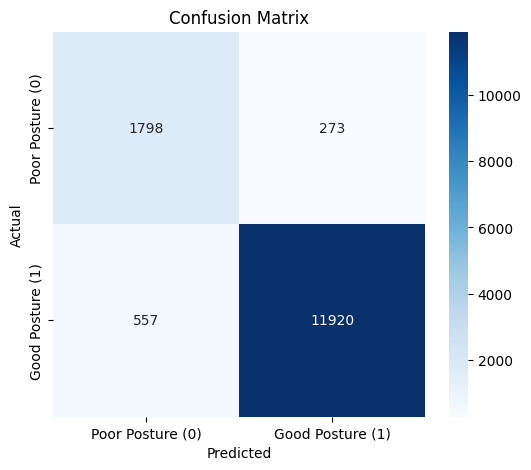


Classification Report:
                  precision    recall  f1-score   support

Poor Posture (0)       0.76      0.87      0.81      2071
Good Posture (1)       0.98      0.96      0.97     12477

        accuracy                           0.94     14548
       macro avg       0.87      0.91      0.89     14548
    weighted avg       0.95      0.94      0.94     14548


Model and scaler saved successfully.


In [13]:

# ================== Evaluation ==================
loss, accuracy = final_model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

y_pred = (final_model.predict(X_test) > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Poor Posture (0)', 'Good Posture (1)'],
            yticklabels=['Poor Posture (0)', 'Good Posture (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Poor Posture (0)', 'Good Posture (1)']))

# ================== Save Model and Scaler ==================
final_model.save('best_cnn_lstm_posture_model_ga.h5')
joblib.dump(scaler, 'minmax_scaler.pkl')
print("\nModel and scaler saved successfully.")


# New Section